# Replicate: CASIA-IVA-Lab FastSAM 
### onnxruntime-gpu (.onnx)

In [1]:
# New conda env

"""
# clean env wipe & activate
conda env remove --name FastSAM_onnx -y
conda create -n FastSAM_onnx python=3.10 -y
conda activate FastSAM_onnx

sudo apt update
sudo apt install libcudnn8 libcudnn8-dev
conda install -c conda-forge libstdcxx-ng=12 -y

# Instalation of FastSAM repo requirements
cd ~/FastSAM
pip install -r requirements.txt
python setup.py install
pip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3


# typical np version mismatch
pip uninstall -y numpy
pip install numpy==1.26.4 

# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)
pip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl

# download torchvision 0.20.0a0 (compatible with jp61 torch)
cd ~/vision/
python3 setup.py install
cd ~

# Install ONNX runtime (general)
pip install onnx==1.13.1 onnxruntime==1.14.1 safetensors==0.4.1 sympy==1.13.1 onnxslim==0.1.59

# Install ONNX runtime for Jetson (GPU support)
wget https://nvidia.box.com/shared/static/48dtuob7meiw6ebgfsfqakc9vse62sg4.whl -O onnxruntime_gpu-1.16.3-cp310-cp310-linux_aarch64.whl
pip install onnxruntime_gpu-1.16.3-cp310-cp310-linux_aarch64.whl

# numpy conflict again !!
pip install "numpy>=1.19.2,<2.0"


pip install git+https://github.com/openai/CLIP.git

"""

# Debug Support

# Check your conda env GLIBCXX versions
# strings /home/copter/miniconda3/envs/nanosam_arm64/lib/python3.10/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6 | grep GLIBCXX

# trt2torch is apparently an issue and is obsolete for trt --version=10.3.0 
# additionally `pip install pycuda`

'\n# clean env wipe & activate\nconda env remove --name FastSAM_onnx -y\nconda create -n FastSAM_onnx python=3.10 -y\nconda activate FastSAM_onnx\n\nsudo apt update\nsudo apt install libcudnn8 libcudnn8-dev\nconda install -c conda-forge libstdcxx-ng=12 -y\n\n# Instalation of FastSAM repo requirements\ncd ~/FastSAM\npip install -r requirements.txt\npython setup.py install\npip install timm==1.0.17 ultralytics==8.0.120 matplotlib==3.5.3\n\n\n# typical np version mismatch\npip uninstall -y numpy\npip install numpy==1.26.4 \n\n# Now install the CUDA PyTorch 2.5.0a0 (compatible with jp61 torch)\npip install --no-cache https://developer.download.nvidia.com/compute/redist/jp/v61/pytorch/torch-2.5.0a0+872d972e41.nv24.08.17622132-cp310-cp310-linux_aarch64.whl\n\n# download torchvision 0.20.0a0 (compatible with jp61 torch)\ncd ~/vision/\npython3 setup.py install\ncd ~\n\n# Install ONNX runtime (general)\npip install onnx==1.13.1 onnxruntime==1.14.1 safetensors==0.4.1 sympy==1.13.1 onnxslim==0.1.

In [2]:
# ONNX FastSAM Inference Setup - Fix cuDNN version issue
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
import torch
from ultralytics.yolo.engine.results import Results
from ultralytics.yolo.utils import ops
from PIL import Image
from random import randint
import os
import sys
from typing import List, Tuple, Any
import time
from random import randint


In [3]:
def postprocess(preds, img, orig_imgs, retina_masks, conf, iou, agnostic_nms=False):
    """
    Post-processes the raw ONNX model predictions to generate segmentation masks and bounding boxes.

    Args:
        preds (list): Raw predictions from the ONNX model.
        img (np.ndarray): Pre-processed input image (resized and normalized).
        orig_imgs (np.ndarray or list): Original un-preprocessed image(s).
        retina_masks (bool): Whether to use retina masks (more detailed).
        conf (float): Confidence threshold for object detection.
        iou (float): IoU threshold for Non-Maximum Suppression (NMS).
        agnostic_nms (bool): Whether to perform class-agnostic NMS.

    Returns:
        list: A list of Results objects containing processed bounding boxes and masks.
    """
    p = ops.non_max_suppression(preds[0],
                                 conf,
                                 iou,
                                 agnostic_nms,
                                 max_det=100,
                                 nc=1) # nc=1 assuming a single class (e.g., 'object') for segmentation

    results = []
    # Adjusting for different ONNX output structures (e.g., if exported with specific opsets)
    proto = preds[1][-1] if len(preds[1]) == 3 else preds[1]
    
    for i, pred in enumerate(p):
        orig_img = orig_imgs[i] if isinstance(orig_imgs, list) else orig_imgs
        img_path = "inference_output" # Placeholder for image path

        if not len(pred):  # save empty boxes
            results.append(Results(orig_img=orig_img, path=img_path, names="segment", boxes=pred[:, :6]))
            continue

        if retina_masks:
            if not isinstance(orig_imgs, torch.Tensor):
                pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
            masks = ops.process_mask_native(proto[i], pred[:, 6:], pred[:, :4], orig_img.shape[:2])  # HWC
        else:
            masks = ops.process_mask(proto[i], pred[:, 6:], pred[:, :4], img.shape[2:], upsample=True)  # HWC
            if not isinstance(orig_imgs, torch.Tensor):
                pred[:, :4] = ops.scale_boxes(img.shape[2:], pred[:, :4], orig_img.shape)
        
        results.append(
            Results(orig_img=orig_img, path=img_path, names="segment", boxes=pred[:, :6], masks=masks))
    return results

def pre_processing(img_origin, imgsz=1024):
    """
    Pre-processes an input image for the FastSAM ONNX model.

    Args:
        img_origin (np.ndarray): The original input image (BGR format).
        imgsz (int): The target image size (height and width) for the model.

    Returns:
        np.ndarray: The pre-processed image, ready for ONNX inference.
                    Shape: (1, 3, imgsz, imgsz) in RGB format, normalized to [0, 1].
    """
    h, w = img_origin.shape[:2]
    if h>w:
        scale   = min(imgsz / h, imgsz / w)
        inp     = np.zeros((imgsz, imgsz, 3), dtype = np.uint8)
        nw      = int(w * scale)
        nh      = int(h * scale)
        a = int((nh-nw)/2) 
        inp[: nh, a:a+nw, :] = cv2.resize(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB), (nw, nh)) # <--- HERE
    else:
        scale   = min(imgsz / h, imgsz / w)
        inp     = np.zeros((imgsz, imgsz, 3), dtype = np.uint8)
        nw      = int(w * scale)
        nh      = int(h * scale)
        a = int((nw-nh)/2) 

        inp[a: a+nh, :nw, :] = cv2.resize(cv2.cvtColor(img_origin, cv2.COLOR_BGR2RGB), (nw, nh)) # <--- AND HERE
    rgb = np.array([inp], dtype = np.float32) / 255.0
    return np.transpose(rgb, (0, 3, 1, 2))

Original Image Shape: (760, 1180, 3)
Input shape for ONNX model: (1, 3, 1024, 1024)


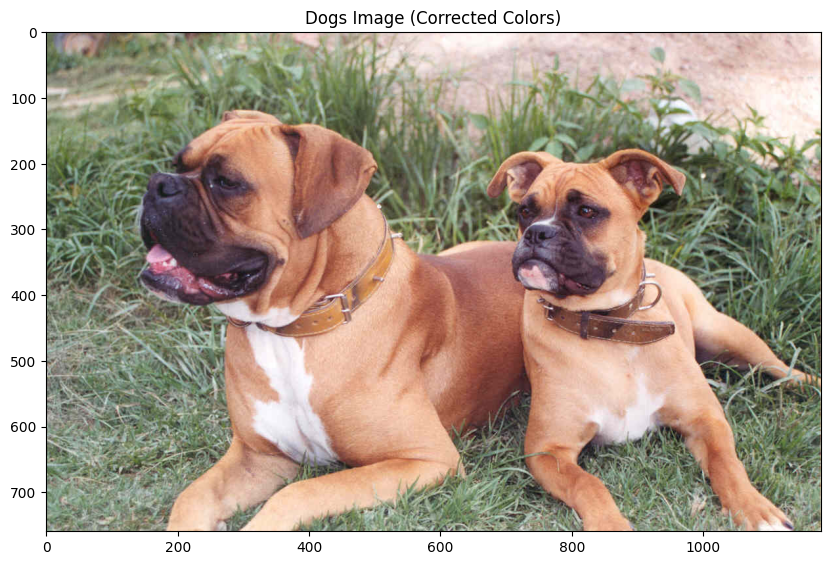

In [4]:
# Load and display image
image_path = "/home/copter/jetson_benchmark/images/dogs.jpg"
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}. Please check the path.")

print(f"Original Image Shape: {img.shape}")

# Pre-process the image for the ONNX model
inp = pre_processing(img)
print('Input shape for ONNX model:', inp.shape)

# Display the image
plt.figure(figsize=(10, 8))
# Convert the image from BGR to RGB before displaying with Matplotlib
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # <--- THIS IS THE FIX
plt.axis('on')
plt.title("Dogs Image (Corrected Colors)") # Changed title to reflect correction
plt.show()

In [5]:
# Add FastSAM utils if needed for compatibility
sys.path.append('/home/copter/FastSAM')

# Update library path to ensure cuDNN is found
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/aarch64-linux-gnu:' + os.environ.get('LD_LIBRARY_PATH', '')

print(f"ONNX Runtime version: {ort.__version__}")

available_providers = ort.get_available_providers()
print(f"Available providers: {available_providers}")

# Now try to set up all providers including CUDA
working_providers = []

# Now try CUDA with cuDNN fix
if 'CUDAExecutionProvider' in available_providers:
    print("✅ CUDA provider available - testing with cuDNN fix...")
    cuda_options = {
        'device_id': 0,
        'arena_extend_strategy': 'kSameAsRequested',
        'gpu_mem_limit': 8 * 1024 * 1024 * 1024,  # 8GB
        'cudnn_conv_algo_search': 'HEURISTIC',
        'intra_op_num_threads': 6, # Added this line
        'inter_op_num_threads': 1, # Added this line, or adjust as needed
    }
    working_providers.append(('CUDAExecutionProvider', cuda_options))

# CPU fallback
cpu_options = {
    'intra_op_num_threads': 6,
    'inter_op_num_threads': 1,
    'enable_cpu_mem_arena': True,
}
working_providers.append(('CPUExecutionProvider', cpu_options))

print(f"Provider chain: {[p[0] if isinstance(p, tuple) else p for p in working_providers]}")
providers = working_providers

ONNX Runtime version: 1.23.0
Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
✅ CUDA provider available - testing with cuDNN fix...
Provider chain: ['CUDAExecutionProvider', 'CPUExecutionProvider']


In [6]:
# Config issues
retina_masks = True
conf = 0.25
iou = 0.7
agnostic_nms = False

In [7]:
# Pre-process the image for the ONNX model
print(f"Original Image Shape: {img.shape}")

# Pre-process the image for the ONNX model
inp = pre_processing(img)
print('Input shape for ONNX model:', inp.shape)

Original Image Shape: (760, 1180, 3)
Input shape for ONNX model: (1, 3, 1024, 1024)


In [8]:
# ONNX model configuration
model_path = "/home/copter/onnx_models/CASIA-IVA-Lab_FastSAM-s.onnx"

# try:
#     model = ort.InferenceSession(model_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
#     print("ONNX model loaded successfully with CUDAExecutionProvider (if available).")
#     model_size_bytes = os.path.getsize(model_path)
#     model_size_mb = model_size_bytes / (1024 * 1024)
#     print(f"ONNX Model Size: {model_size_mb:.2f} MB")
# except Exception as e:
#     print(f"Could NOT load ONNX model with CUDAExecutionProvider, trying with CPUExecutionProvider: {e}")
#     model = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
#     print("ONNX model loaded successfully with CPUExecutionProvider.")


In [9]:
# (Optional) FORCE GPU

# List available providers
providers = ort.get_available_providers()
print("Available providers:", providers)

# Configure session options (for threading)
session_options = ort.SessionOptions()
session_options.intra_op_num_threads = 6
session_options.inter_op_num_threads = 1
session_options.execution_mode = ort.ExecutionMode.ORT_SEQUENTIAL

# Try to use GPU providers in order of preference
gpu_providers = []

if 'TensorrtExecutionProvider' in providers:
    gpu_providers.append('TensorrtExecutionProvider')

# GPU Config for CUDA provider
if 'CUDAExecutionProvider' in providers:
    print("✅ CUDA provider available!")
    cuda_options = {
        'device_id': 0,
        'arena_extend_strategy': 'kSameAsRequested',
        'gpu_mem_limit': 8 * 1024 * 1024 * 1024,  # 8GB
        'cudnn_conv_algo_search': 'HEURISTIC',
    }
    gpu_providers.append(('CUDAExecutionProvider', cuda_options))

# Add CPU as fallback
# gpu_providers.append('CPUExecutionProvider')

print("Using ver: `gpu_providers` providers:", gpu_providers)

# Load model with explicit providers AND session options
model = ort.InferenceSession(model_path, providers=gpu_providers, sess_options=session_options)
print("Actually using providers:", model.get_providers())

Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
✅ CUDA provider available!
Using ver: `gpu_providers` providers: ['TensorrtExecutionProvider', ('CUDAExecutionProvider', {'device_id': 0, 'arena_extend_strategy': 'kSameAsRequested', 'gpu_mem_limit': 8589934592, 'cudnn_conv_algo_search': 'HEURISTIC'})]
Actually using providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']


In [10]:
import onnxruntime as ort

# Check available providers
print("Available providers:", ort.get_available_providers())

# Check what your model session is using
print("Model session providers:", model.get_providers())

# Get provider options
session_options = ort.SessionOptions()
print("Session options:", session_options)

Available providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Model session providers: ['TensorrtExecutionProvider', 'CUDAExecutionProvider', 'CPUExecutionProvider']
Session options: <onnxruntime.capi.onnxruntime_pybind11_state.SessionOptions object at 0xfffe9f78bcf0>


In [11]:
# ---- MAIN TIMING BENCH (in MS) ------------------------------- # 

import time

# Prepare inputs for the ONNX model
ort_inputs = {model.get_inputs()[0].name: inp}

# Warm-up runs (important for accurate timing)
print("Performing warm-up runs...")
for _ in range(5):
    _ = model.run(None, ort_inputs)
print("Warm-up complete.")

num_runs = 50 # Number of inference runs for averaging
inference_times = []

print(f"Starting {num_runs} inference runs...")
for i in range(num_runs):
    start_time = time.time()
    preds = model.run(None, ort_inputs)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    if (i + 1) % 10 == 0:
        print(f"  Run {i+1}/{num_runs} completed.")

average_inference_time_ms = (sum(inference_times) / num_runs) * 1000
print(f"\nAverage Inference Speed (ONNX CUDA): {average_inference_time_ms:.2f} ms per image")
print(f"Raw ONNX prediction shapes: {[x.shape for x in preds]}")

Performing warm-up runs...
Warm-up complete.
Starting 50 inference runs...
  Run 10/50 completed.
  Run 20/50 completed.
  Run 30/50 completed.
  Run 40/50 completed.
  Run 50/50 completed.

Average Inference Speed (ONNX CUDA): 107.19 ms per image
Raw ONNX prediction shapes: [(1, 37, 21504), (1, 65, 128, 128), (1, 65, 64, 64), (1, 65, 32, 32), (1, 32, 21504), (1, 32, 256, 256)]


In [22]:
# The standard and correct way to monitor resources on any Jetson device is to use 
# the jetson-stats utility and its corresponding Python library, jtop.

import time
from jtop import jtop # Import the jtop library

# --- Your original model setup code here ---
# import onnxruntime
# model = onnxruntime.InferenceSession(...)
# inp = ...
# -----------------------------------------

# Initialize jtop
# It's best to do this once and close it when you're done
jetson = jtop()
jetson.start()

def get_gpu_memory():
    # Access GPU-specific memory usage from the jtop stats
    # jtop provides values in bytes, so we convert to GB
    return jetson.memory['RAM']['used'] / (1024**3)

try:
    # Get baseline
    baseline_memory = get_gpu_memory()
    peak_memory = baseline_memory

    # Your inference code with memory tracking
    ort_inputs = {model.get_inputs()[0].name: inp}

    print("Performing warm-up runs...")
    for _ in range(5):
        _ = model.run(None, ort_inputs)
        peak_memory = max(peak_memory, get_gpu_memory())
    print("Warm-up complete.")

    num_runs = 50
    inference_times = []
    print(f"Starting {num_runs} inference runs...")

    for i in range(num_runs):
        start_time = time.time()
        preds = model.run(None, ort_inputs)
        end_time = time.time()
        
        # Check memory after each inference
        current_memory = get_gpu_memory()
        current_memory_mb = 1000*current_memory

        peak_memory = max(peak_memory, current_memory)
        peak_memory_mb = 1000*peak_memory
        
        inference_times.append(end_time - start_time)
        if (i + 1) % 10 == 0:
            print(f" Run {i+1}/{num_runs} completed. Current GPU memory: {current_memory:.2f} GB, ({current_memory_mb:.2f} MB)")

    average_inference_time_ms = (sum(inference_times) / num_runs) * 1000
    print(f"\nAverage Inference Speed (ONNX CUDA): {average_inference_time_ms:.2f} ms per image")
    print(f"Raw ONNX prediction shapes: {[x.shape for x in preds]}")
    print(f"Baseline GPU memory: {baseline_memory:.2f} GB")
    print(f"Peak GPU memory usage: {peak_memory:.2f} GB  ({peak_memory_mb:.2f} MB)")
    print(f"Memory increase: {peak_memory - baseline_memory:.2f} GB")

finally:
    # Always make sure to close the jtop instance to release resources
    jetson.close()
    print("\njtop closed...")

Performing warm-up runs...
Warm-up complete.
Starting 50 inference runs...
 Run 10/50 completed. Current GPU memory: 0.02 GB, (22.43 MB)
 Run 20/50 completed. Current GPU memory: 0.02 GB, (22.43 MB)
 Run 30/50 completed. Current GPU memory: 0.02 GB, (22.44 MB)
 Run 40/50 completed. Current GPU memory: 0.02 GB, (22.44 MB)
 Run 50/50 completed. Current GPU memory: 0.02 GB, (22.44 MB)

Average Inference Speed (ONNX CUDA): 113.30 ms per image
Raw ONNX prediction shapes: [(1, 37, 21504), (1, 65, 128, 128), (1, 65, 64, 64), (1, 65, 32, 32), (1, 32, 21504), (1, 32, 256, 256)]
Baseline GPU memory: 0.02 GB
Peak GPU memory usage: 0.02 GB  (22.57 MB)
Memory increase: 0.00 GB

 jtop closed.


In [ ]:
## Using gpustat

import subprocess
import time
import threading
import re

class GPUMemoryMonitor:
    def __init__(self):
        self.max_memory = 0
        self.monitoring = False
        self.memory_history = []
    
    def get_gpu_memory(self):
        try:
            result = subprocess.run(['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'], 
                                  capture_output=True, text=True)
            if result.returncode == 0:
                memory_mb = float(result.stdout.strip())
                return memory_mb / 1024  # Convert to GB
        except:
            pass
        return 0
    
    def monitor_memory(self):
        while self.monitoring:
            current_memory = self.get_gpu_memory()
            if current_memory > 0:
                self.max_memory = max(self.max_memory, current_memory)
                self.memory_history.append(current_memory)
            time.sleep(0.1)  # Check every 100ms
    
    def start_monitoring(self):
        self.monitoring = True
        self.monitor_thread = threading.Thread(target=self.monitor_memory)
        self.monitor_thread.start()
    
    def stop_monitoring(self):
        self.monitoring = False
        if hasattr(self, 'monitor_thread'):
            self.monitor_thread.join()

# Initialize monitor
gpu_monitor = GPUMemoryMonitor()

# Get baseline memory usage
baseline_memory = gpu_monitor.get_gpu_memory()
print(f"Baseline GPU memory usage: {baseline_memory:.2f} GB")

# Start monitoring
gpu_monitor.start_monitoring()

# Your inference code
ort_inputs = {model.get_inputs()[0].name: inp}

# Warm-up runs
print("Performing warm-up runs...")
for _ in range(5):
    _ = model.run(None, ort_inputs)
print("Warm-up complete.")

# Reset peak memory after warm-up
gpu_monitor.max_memory = baseline_memory

num_runs = 50
inference_times = []
print(f"Starting {num_runs} inference runs...")

for i in range(num_runs):
    start_time = time.time()
    preds = model.run(None, ort_inputs)
    end_time = time.time()
    inference_times.append(end_time - start_time)
    if (i + 1) % 10 == 0:
        print(f" Run {i+1}/{num_runs} completed.")

# Stop monitoring
gpu_monitor.stop_monitoring()

# Results
average_inference_time_ms = (sum(inference_times) / num_runs) * 1000
peak_memory_usage = gpu_monitor.max_memory
memory_increase = peak_memory_usage - baseline_memory

print(f"\nAverage Inference Speed (ONNX CUDA): {average_inference_time_ms:.2f} ms per image")
print(f"Raw ONNX prediction shapes: {[x.shape for x in preds]}")
print(f"Peak GPU memory usage during inference: {peak_memory_usage:.2f} GB")
print(f"Memory increase from baseline: {memory_increase:.2f} GB")

In [ ]:
# CUDA tracking

import time
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    
    def get_gpu_memory():
        torch.cuda.synchronize()
        return torch.cuda.memory_allocated(device) / (1024**3)  # GB
    
    def get_max_gpu_memory():
        torch.cuda.synchronize()
        return torch.cuda.max_memory_allocated(device) / (1024**3)  # GB
    
    # Reset memory stats
    torch.cuda.reset_peak_memory_stats(device)
    
    # Get baseline
    baseline_memory = get_gpu_memory()
    print(f"Baseline GPU memory usage: {baseline_memory:.2f} GB")
    
    # Your inference code
    ort_inputs = {model.get_inputs()[0].name: inp}
    
    # Warm-up runs
    print("Performing warm-up runs...")
    for _ in range(5):
        _ = model.run(None, ort_inputs)
    print("Warm-up complete.")
    
    # Reset peak memory stats after warm-up
    torch.cuda.reset_peak_memory_stats(device)
    
    num_runs = 50
    inference_times = []
    print(f"Starting {num_runs} inference runs...")
    
    for i in range(num_runs):
        start_time = time.time()
        preds = model.run(None, ort_inputs)
        end_time = time.time()
        inference_times.append(end_time - start_time)
        if (i + 1) % 10 == 0:
            current_memory = get_gpu_memory()
            print(f" Run {i+1}/{num_runs} completed. Current GPU memory: {current_memory:.2f} GB")
    
    # Get peak memory
    peak_memory = get_max_gpu_memory()
    
    # Results
    average_inference_time_ms = (sum(inference_times) / num_runs) * 1000
    print(f"\nAverage Inference Speed (ONNX CUDA): {average_inference_time_ms:.2f} ms per image")
    print(f"Raw ONNX prediction shapes: {[x.shape for x in preds]}")
    print(f"Peak GPU memory usage during inference: {peak_memory:.2f} GB")
    print(f"Final GPU memory usage: {get_gpu_memory():.2f} GB")

else:
    print("CUDA not available for PyTorch memory tracking")

In [ ]:
# Nvidia SMI Approach 

import subprocess
import time

def get_gpu_memory_usage():
    """Get current GPU memory usage in GB"""
    try:
        result = subprocess.run([
            'nvidia-smi', '--query-gpu=memory.used', 
            '--format=csv,noheader,nounits,query-gpu=0'
        ], capture_output=True, text=True, timeout=5)
        
        if result.returncode == 0:
            memory_mb = float(result.stdout.strip())
            return memory_mb / 1024  # Convert MB to GB
    except Exception as e:
        print(f"Error getting GPU memory: {e}")
    return 0

# Get baseline memory
baseline_memory = get_gpu_memory_usage()
peak_memory = baseline_memory
print(f"Baseline GPU memory usage: {baseline_memory:.2f} GB")

# Your inference code
ort_inputs = {model.get_inputs()[0].name: inp}

# Warm-up runs
print("Performing warm-up runs...")
for _ in range(5):
    _ = model.run(None, ort_inputs)
    current_memory = get_gpu_memory_usage()
    peak_memory = max(peak_memory, current_memory)
print("Warm-up complete.")

num_runs = 50
inference_times = []
print(f"Starting {num_runs} inference runs...")

for i in range(num_runs):
    start_time = time.time()
    preds = model.run(None, ort_inputs)
    end_time = time.time()
    
    # Check memory periodically
    if i % 5 == 0:  # Check every 5 runs to reduce overhead
        current_memory = get_gpu_memory_usage()
        peak_memory = max(peak_memory, current_memory)
    
    inference_times.append(end_time - start_time)
    if (i + 1) % 10 == 0:
        current_memory = get_gpu_memory_usage()
        peak_memory = max(peak_memory, current_memory)
        print(f" Run {i+1}/{num_runs} completed. Current GPU memory: {current_memory:.2f} GB")

# Final memory check
final_memory = get_gpu_memory_usage()
peak_memory = max(peak_memory, final_memory)

# Results
average_inference_time_ms = (sum(inference_times) / num_runs) * 1000
memory_increase = peak_memory - baseline_memory

print(f"\nAverage Inference Speed (ONNX CUDA): {average_inference_time_ms:.2f} ms per image")
print(f"Raw ONNX prediction shapes: {[x.shape for x in preds]}")
print(f"Baseline GPU memory: {baseline_memory:.2f} GB")
print(f"Peak GPU memory usage: {peak_memory:.2f} GB")
print(f"Memory increase from baseline: {memory_increase:.2f} GB")
print(f"Final GPU memory: {final_memory:.2f} GB")

In [ ]:
# ---- IS THIS CPU CONSUMPTION ??? ------------------------------- # 

import psutil
import os

# Get current process info
process = psutil.Process(os.getpid())

print(f"Process PID: {process.pid}")
print(f"CPU count: {psutil.cpu_count()}")

# Monitor during inference
cpu_percentages = []
memory_usage = []

for i in range(num_runs):
    # Your existing inference code
    start_time = time.time()
    preds = model.run(None, ort_inputs)
    end_time = time.time()
    
    # Monitor resource usage
    cpu_percent = process.cpu_percent()
    memory_mb = process.memory_info().rss / (1024*1024)
    
    cpu_percentages.append(cpu_percent)
    memory_usage.append(memory_mb)
    
    inference_times.append(end_time - start_time)
    if (i + 1) % 10 == 0:
        print(f" Run {i+1}/{num_runs} completed. CPU: {cpu_percent:.1f}%, Memory: {memory_mb:.1f}MB")

print(f"\nAverage CPU usage during inference: {sum(cpu_percentages)/len(cpu_percentages):.1f}%")
print(f"Peak memory usage: {max(memory_usage):.1f}MB")

In [ ]:
import subprocess
import torch
import onnxruntime as ort
import numpy as np


def get_gpu_mem_nvidia_smi():
    out = subprocess.check_output(
        ["nvidia-smi",
         "--query-gpu=memory.used",
         "--format=csv,nounits,noheader"]
    )
    val = out.strip().split()[0]
    return int(val)  # may raise ValueError if val == b'[N/A]'

# 1) Load your session
model_path = "/home/copter/onnx_models/CASIA-IVA-Lab_FastSAM-s.onnx"
model = ort.InferenceSession(model_path,
                             providers=["CUDAExecutionProvider","CPUExecutionProvider"])

# 2) Prepare inputs
ort_inputs = {model.get_inputs()[0].name: inp}

# 3) Warm up & sync
torch.cuda.synchronize()

# 4) Try snapshot before inference
try:
    mem_before = get_gpu_mem_nvidia_smi()  # MiB
except Exception:
    mem_before = None

# 5) Setup CUDA events
start_evt = torch.cuda.Event(enable_timing=True)
end_evt   = torch.cuda.Event(enable_timing=True)

# 6) Run inference
start_evt.record()
preds = model.run(None, ort_inputs)
end_evt.record()

# 7) Wait for GPU
torch.cuda.synchronize()

# 8) Try snapshot after inference
try:
    mem_after = get_gpu_mem_nvidia_smi()   # MiB
except Exception:
    mem_after = None

# 9) Compute GPU timing
gpu_time_s = start_evt.elapsed_time(end_evt) / 1000.0

print(f"ONNX Runtime GPU inference time: {gpu_time_s:.3f} s")

# 10) Print GPU memory delta if both snapshots succeeded
if mem_before is not None and mem_after is not None:
    print(f"GPU memory increase: {mem_after - mem_before:.2f} MB")
else:
    print("GPU memory measurement unavailable; skipping delta.")

print(f"Raw ONNX prediction shapes: {[x.shape for x in preds]}")

# — Post‑processing as before —
predictions_for_postprocess = [
    torch.from_numpy(preds[0]),
    [
        [torch.from_numpy(preds[1]), torch.from_numpy(preds[2]), torch.from_numpy(preds[3])],
        torch.from_numpy(preds[4]),
        torch.from_numpy(preds[5])
    ]
]

result = postprocess(predictions_for_postprocess, inp, img, retina_masks, conf, iou)
masks  = result[0].masks.data
scores = result[0].boxes.data[:, 4].cpu().numpy()

print(f"Number of detected masks: {len(masks)}")
image_with_masks_final = np.copy(img)


In [ ]:
## ORIGINAL

# Prepare inputs for the ONNX model
ort_inputs = {model.get_inputs()[0].name: inp}

# Run inference
preds = model.run(None, ort_inputs)
print(f"Raw ONNX prediction shapes: {[x.shape for x in preds]}")

# Reconstructing `predictions_for_postprocess` as the `postprocess` function expects.
# This part is crucial and depends on your specific ONNX model export.
predictions_for_postprocess = [
    torch.from_numpy(preds[0]), # This is `preds[0]` in the `postprocess` function
    [
        [torch.from_numpy(preds[1]), torch.from_numpy(preds[2]), torch.from_numpy(preds[3])],
        torch.from_numpy(preds[4]),
        torch.from_numpy(preds[5])
    ] # This complex structure becomes `preds[1]` in the `postprocess` function
]

# Perform post-processing
result = postprocess(predictions_for_postprocess, inp, img, retina_masks, conf, iou)

# Extract masks and scores from the first result (assuming single image inference)
# Make sure your `result[0]` actually contains `masks.data` and `boxes.data`
# From the `postprocess` function: `boxes=pred[:, :6], masks=masks`
# So, `result[0].masks.data` should be available.
masks = result[0].masks.data # This is a torch.Tensor of shape (N, H, W) for N masks
# You also need scores to pick the best mask. Let's assume scores are in the 5th column of `pred` (index 4)
# from `ops.non_max_suppression`, which is then part of `result[0].boxes.data`.
scores = result[0].boxes.data[:, 4].cpu().numpy() # Extract scores and convert to numpy

print(f"Number of detected masks: {len(masks)}")

# Ensure image_with_masks_final is always defined
image_with_masks_final = np.copy(img) # Initialize with original image (BGR) in case no masks are found

In [ ]:



# --- New Mask Visualization Logic ---
if len(masks) > 0:
    # 1) Pick the best mask based on score
    scores_flat = scores.flatten()
    best_idx    = int(np.argmax(scores_flat))
    print(f"Best mask idx: {best_idx}   score: {scores_flat[best_idx]:.3f}")

    # Convert the best mask to numpy for PIL
    # Ensure mask_out is a 2D tensor (H, W) or convert if it's (1, H, W)
    raw_mask_tensor = masks[best_idx]
    if raw_mask_tensor.ndim == 3 and raw_mask_tensor.shape[0] == 1:
        raw_mask_tensor = raw_mask_tensor.squeeze(0) # Remove batch dimension if present

    raw_mask = raw_mask_tensor.cpu().numpy() # (H_mask,W_mask) in [0,1]

    # Get original image dimensions for resizing
    h_orig, w_orig = img.shape[:2]

    # 2) Extract, threshold, and resize the mask
    binary    = (raw_mask > 0.5).astype(np.uint8) * 255
    mask_img  = Image.fromarray(binary)
    mask_rs   = mask_img.resize((w_orig, h_orig), Image.BILINEAR) # Resize to original image size

    # 3) Build a 20%‑opaque red overlay
    alpha_mask = mask_rs.point(lambda p: int(p * 0.3)) # Scale to 0-51 (20% of 255)
    red_layer  = Image.new("RGBA", (w_orig, h_orig), (0, 255, 0, 0))
    red_layer.putalpha(alpha_mask)

    # Convert the original image (BGR to RGB) and then to PIL Image for overlaying
    img_rgb_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    # Overlay the red layer onto the original image
    image_with_masks_pil = Image.alpha_composite(img_rgb_pil.convert("RGBA"), red_layer)
    
    # Convert back to OpenCV BGR format for saving with cv2.imwrite
    image_with_masks = cv2.cvtColor(np.array(image_with_masks_pil), cv2.COLOR_RGBA2BGR)
else:
    print("No masks detected to display.")
    image_with_masks = np.copy(img) # If no masks, just keep the original image

# Save the segmented image
output_path = "/home/copter/jetson_benchmark/output/FastSAM_onnx_output.png" # Update this path for your output
cv2.imwrite(output_path, image_with_masks)
print(f"Segmented image saved to {output_path}")

In [ ]:
# Display the image (optional, for Jupyter)
display_img = cv2.imread(output_path)
if display_img is None:
    raise FileNotFoundError(f"Could not read the saved image from {output_path}")

# Display the image (optional, for Jupyter)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
# Convert from BGR (cv2.imread default) to RGB for matplotlib display
plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.title("Segmented Mask using FastSAM.onnx")
plt.show()


In [ ]:
class FastSAMONNX:
    def __init__(self, model_path: str, providers: List):
        """Initialize ONNX FastSAM model with cuDNN version fix"""
        self.session = None
        self.working_provider = None
        
        # Test each provider to see which actually works
        for i, provider in enumerate(providers):
            provider_name = provider[0] if isinstance(provider, tuple) else provider
            
            try:
                print(f"🔄 Testing {provider_name}...")
                
                # Configure session for Jetson
                sess_options = ort.SessionOptions()
                sess_options.inter_op_num_threads = 4
                sess_options.intra_op_num_threads = 4
                sess_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
                sess_options.enable_cpu_mem_arena = True
                
                # Create session with single provider to test
                test_session = ort.InferenceSession(
                    model_path, 
                    providers=[provider],
                    sess_options=sess_options
                )
                
                # If we get here, the provider works
                self.session = test_session
                self.working_provider = provider_name
                print(f"✅ {provider_name} working successfully!")
                
                # Show which provider is actually being used
                active_providers = self.session.get_providers()
                print(f"   Active providers in session: {active_providers}")
                break
                
            except Exception as e:
                error_msg = str(e)
                print(f"❌ {provider_name} failed: {error_msg[:200]}...")
                
                # Specific error messages
                if 'libcudnn.so.8' in error_msg:
                    print("   💡 cuDNN version mismatch - symlink may not have worked")
                elif 'CUDA' in error_msg and 'initialization' in error_msg:
                    print("   💡 CUDA initialization failed")
                elif 'TensorRT' in error_msg:
                    print("   💡 TensorRT engine compilation issue")
                
                if i == len(providers) - 1:
                    raise Exception(f"All providers failed. Last error: {e}")
                continue
        
        if self.session is None:
            raise Exception("No working provider found")
        
        # Get model information
        self.input_name = self.session.get_inputs()[0].name
        self.output_names = [output.name for output in self.session.get_outputs()]
        
        input_shape = self.session.get_inputs()[0].shape
        self.input_height = 1024 if isinstance(input_shape[2], str) or input_shape[2] == -1 else input_shape[2]
        self.input_width = 1024 if isinstance(input_shape[3], str) or input_shape[3] == -1 else input_shape[3]
        
        print(f"\n📊 Model successfully loaded:")
        print(f"   🚀 Active provider: {self.working_provider}")
        print(f"   📐 Input size: {self.input_height}x{self.input_width}")
        print(f"   📤 Outputs: {len(self.output_names)}")
        
        # Performance expectations
        if self.working_provider == 'TensorrtExecutionProvider':
            print(f"   ⚡ Expected performance: Excellent (first run will be slow for engine compilation)")
        elif self.working_provider == 'CUDAExecutionProvider':
            print(f"   ⚡ Expected performance: Very Good")
        else:
            print(f"   ⚡ Expected performance: Good (CPU optimized for ARM64)")
    
    def preprocess_image(self, image: Image.Image, target_size: int = 1024) -> Tuple[np.ndarray, float, Tuple[int, int]]:
        """Preprocess image for ONNX inference"""
        img_array = np.array(image)
        original_h, original_w = img_array.shape[:2]
        original_size = (original_w, original_h)
        
        scale = min(target_size / original_w, target_size / original_h)
        new_w = int(original_w * scale)
        new_h = int(original_h * scale)
        
        img_resized = cv2.resize(img_array, (new_w, new_h))
        padded_img = np.zeros((target_size, target_size, 3), dtype=np.uint8)
        padded_img[:new_h, :new_w] = img_resized
        
        img_input = padded_img.astype(np.float32) / 255.0
        img_input = np.transpose(img_input, (2, 0, 1))
        img_input = np.expand_dims(img_input, axis=0)
        
        return img_input, scale, original_size
    
    def postprocess_masks(self, outputs: List[np.ndarray], original_size: Tuple[int, int], 
                         scale: float, conf_threshold: float = 0.4) -> np.ndarray:
        """Postprocess ONNX outputs"""
        if len(outputs) == 0 or outputs[0] is None:
            return np.array([])
        
        masks_output = outputs[0]
        
        if len(masks_output.shape) == 4:
            masks = masks_output[0]
        elif len(masks_output.shape) == 3:
            masks = masks_output
        else:
            print(f"Unexpected output shape: {masks_output.shape}")
            return np.array([])
        
        print(f"Processing {masks.shape[0]} masks")
        
        processed_masks = []
        target_w, target_h = original_size[0], original_size[1]
        
        for mask in masks:
            if mask.dtype == np.float32:
                binary_mask = (mask > 0.5).astype(np.uint8)
            else:
                binary_mask = mask.astype(np.uint8)
            
            if binary_mask.shape != (target_h, target_w):
                resized_mask = cv2.resize(binary_mask, (target_w, target_h))
            else:
                resized_mask = binary_mask
            
            processed_masks.append(resized_mask)
        
        return np.array(processed_masks)
    
    def inference(self, image: Image.Image, conf_threshold: float = 0.4) -> np.ndarray:
        """Run inference"""
        try:
            img_input, scale, original_size = self.preprocess_image(image, self.input_height)
            
            provider_emoji = {
                'TensorrtExecutionProvider': '🏎️',
                'CUDAExecutionProvider': '🚀', 
                'CPUExecutionProvider': '🖥️'
            }
            
            emoji = provider_emoji.get(self.working_provider, '⚡')
            print(f"{emoji} Running {self.working_provider} inference...")
            
            start_time = time.time()
            outputs = self.session.run(self.output_names, {self.input_name: img_input})
            inference_time = time.time() - start_time
            
            print(f"⏱️ Inference completed in {inference_time:.3f}s")
            
            masks = self.postprocess_masks(outputs, original_size, scale, conf_threshold)
            return masks
            
        except Exception as e:
            print(f"Inference error: {e}")
            return np.array([])

# Initialize model
try:
    fastsam_onnx = FastSAMONNX(model_path, providers)
except Exception as e:
    print(f"❌ Model initialization failed: {e}")


# class FastSAMONNX:
#     def __init__(self, model_path: str, providers: List[str]):
#         """Initialize ONNX FastSAM model"""
#         self.session = ort.InferenceSession(model_path, providers=providers)
#         self.input_name = self.session.get_inputs()[0].name
#         self.output_names = [output.name for output in self.session.get_outputs()]
        
#         # Get input shape
#         input_shape = self.session.get_inputs()[0].shape
#         self.input_height = input_shape[2] if input_shape[2] != -1 else 1024
#         self.input_width = input_shape[3] if input_shape[3] != -1 else 1024
        
#         print(f"Model input shape: {input_shape}")
#         print(f"Model outputs: {self.output_names}")
    
#     def preprocess_image(self, image: Image.Image, target_size: int = 1024) -> Tuple[np.ndarray, float]:
#         """Preprocess image for ONNX inference"""
#         # Convert PIL to numpy
#         img_array = np.array(image)
#         original_h, original_w = img_array.shape[:2]
        
#         # Calculate scaling factor
#         scale = min(target_size / original_w, target_size / original_h)
#         new_w = int(original_w * scale)
#         new_h = int(original_h * scale)
        
#         # Resize image
#         img_resized = cv2.resize(img_array, (new_w, new_h))
        
#         # Create padded image
#         padded_img = np.zeros((target_size, target_size, 3), dtype=np.uint8)
#         padded_img[:new_h, :new_w] = img_resized
        
#         # Normalize and transpose for model input
#         img_input = padded_img.astype(np.float32) / 255.0
#         img_input = np.transpose(img_input, (2, 0, 1))  # HWC -> CHW
#         img_input = np.expand_dims(img_input, axis=0)   # Add batch dimension
        
#         return img_input, scale
    
#     def postprocess_masks(self, outputs: List[np.ndarray], original_size: Tuple[int, int], 
#                          scale: float, conf_threshold: float = 0.4) -> np.ndarray:
#         """Postprocess ONNX outputs to get masks"""
#         # This depends on your specific ONNX model output format
#         # Adjust based on your FastSAM ONNX model structure
        
#         if len(outputs) > 0:
#             # Assuming first output contains masks
#             masks = outputs[0]
            
#             # Apply confidence threshold if needed
#             if len(outputs) > 1:  # If confidence scores are separate
#                 scores = outputs[1]
#                 valid_masks = scores > conf_threshold
#                 masks = masks[valid_masks]
            
#             return masks
        
#         return np.array([])
    
#     def inference(self, image: Image.Image, conf_threshold: float = 0.4) -> np.ndarray:
#         """Run inference on image"""
#         # Preprocess
#         img_input, scale = self.preprocess_image(image, self.input_height)
        
#         # Run inference
#         start_time = time.time()
#         outputs = self.session.run(self.output_names, {self.input_name: img_input})
#         inference_time = time.time() - start_time
        
#         print(f"Inference time: {inference_time:.3f}s")
        
#         # Postprocess
#         masks = self.postprocess_masks(outputs, image.size, scale, conf_threshold)
        
#         return masks

# # Initialize ONNX model
# fastsam_onnx = FastSAMONNX(model_path, providers)

In [ ]:
# Run inference
print("Running ONNX inference...")
masks = fastsam_onnx.inference(image, conf_threshold=conf)

print(f"Generated {len(masks)} masks")

# Apply prompts
filtered_masks = apply_prompts(
    masks, image, 
    box_prompt=box_prompt if box_prompt != [[0,0,0,0]] else None,
    point_prompt=point_prompt if point_prompt != [[0,0]] else None,
    point_label=point_label,
    text_prompt=text_prompt
)

print(f"After filtering: {len(filtered_masks)} masks")

In [ ]:
def visualize_masks(image: Image.Image, masks: np.ndarray, 
                   output_path: str, random_color: bool = True):
    """Visualize masks on image"""
    if len(masks) == 0:
        print("No masks to visualize")
        return
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    
    # Generate colors
    if random_color:
        colors = np.random.rand(len(masks), 3)
    else:
        colors = plt.cm.Set3(np.linspace(0, 1, len(masks)))
    
    # Overlay masks
    for i, mask in enumerate(masks):
        # Resize mask to image size if needed
        if mask.shape != image.size[::-1]:  # PIL size is (W,H), numpy is (H,W)
            mask = cv2.resize(mask.astype(np.uint8), image.size)
        
        colored_mask = np.zeros((*mask.shape, 4))
        colored_mask[:, :, :3] = colors[i][:3]
        colored_mask[:, :, 3] = mask * 0.6  # Alpha channel
        
        ax.imshow(colored_mask)
    
    ax.set_title(f"FastSAM ONNX Results - {len(masks)} masks")
    ax.axis('off')
    
    # Save result
    plt.savefig(output_path, bbox_inches='tight', dpi=150)
    plt.show()
    
    print(f"Results saved to: {output_path}")

# Visualize results
output_path = os.path.join(output_dir, "fastsam_onnx_result.jpg")
visualize_masks(image, filtered_masks, output_path, randomcolor)

In [ ]:
# Performance monitoring
def benchmark_inference(model: FastSAMONNX, image: Image.Image, num_runs: int = 10):
    """Benchmark inference performance"""
    times = []
    
    print(f"Running {num_runs} inference iterations...")
    for i in range(num_runs):
        start_time = time.time()
        masks = model.inference(image, conf_threshold=conf)
        end_time = time.time()
        
        inference_time = end_time - start_time
        times.append(inference_time)
        
        if i == 0:
            print(f"First run: {inference_time:.3f}s ({len(masks)} masks)")
    
    avg_time = np.mean(times)
    std_time = np.std(times)
    
    print(f"\nBenchmark Results:")
    print(f"Average inference time: {avg_time:.3f}s ± {std_time:.3f}s")
    print(f"FPS: {1.0/avg_time:.1f}")
    print(f"Min time: {min(times):.3f}s")
    print(f"Max time: {max(times):.3f}s")

# Run benchmark
benchmark_inference(fastsam_onnx, image, num_runs=5)